In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

prcp_database = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-04-04").\
    filter(Measurement.date <= "2017-04-04").all()

# Perform a query to retrieve the data and precipitation scores
prcp_score = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_database).set_index('date')
prcp_df=prcp_df.rename(columns={'prcp':'precipitation'})
# Sort the dataframe by date
prcp_df=prcp_df.sort_values(by='date').dropna()
prcp_df.head()



,precipitation
date,
2016-04-04,0.0
2016-04-04,0.0
2016-04-04,0.0
2016-04-04,0.0
2016-04-04,0.0


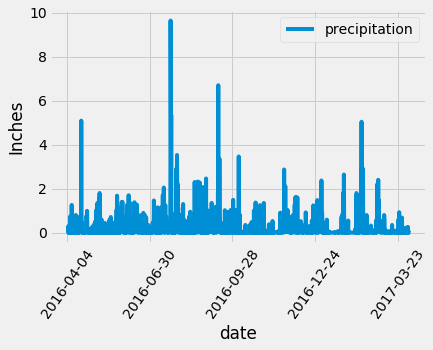

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=55)
plt.savefig("Precip Analysis.png") 
plt.ylabel("Inches")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2071.000000
mean,0.202931
std,0.548851
min,0.000000
25%,0.000000
50%,0.020000
75%,0.150000
max,9.640000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_nub = session.query(Station).group_by(Station.id).count() 
print(f'Number of stations {station_nub}.')

Number of stations 9.


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
active_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


station_number = "USC00519281"
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == station_number).all()

[(54.0, 85.0, 71.66378066378067)]

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_station = active_station[0][0]

outcome = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= "2016-04-04").\
                        filter(Measurement.date <= "2017-04-04").\
                        filter(Measurement.station == highest_station).all()

# convert to dataframe
outcome_df = pd.DataFrame(outcome)



Text(0.5, 0, 'Temperature')

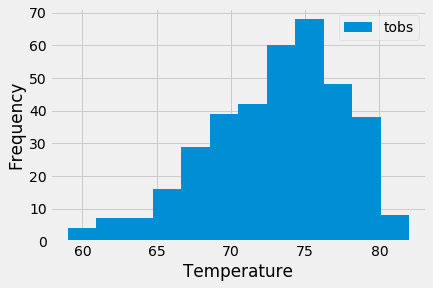

In [17]:
# historgram 
outcome_df.plot.hist(bins=12)
plt.xlabel('Temperature')

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2012-02-28', '2012-03-05'))
Tmin, Tavg, Tmax = calc_temps('2012-02-28', '2012-03-05')[0]

[(62.0, 69.57142857142857, 74.0)]


C:\Users\ppaim\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


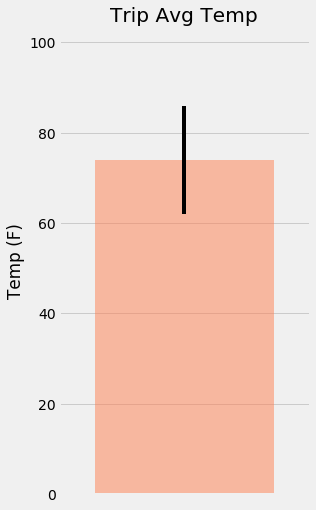

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
yerr = Tmax-Tmin
xpos = 1
bar = ax.bar(xpos, Tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
fig.show()


In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

startdate = '2012-02-28'
enddate = '2012-03-05'

result = session.query(Station.station,  Station.name, Station.latitude, Station.longitude, Station.elevation).\
   filter(Station.station == Measurement.station).\
       filter(Measurement.date >= 'startdate').filter(Measurement.date <= 'enddate').\
           group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

stations = pd.DataFrame(result, columns=['Station','Name','Latitude','Longitude','Elevation','Prcp'])
stations.head()

,Station,Name,Latitude,Longitude,Elevation,Prcp


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
